In [33]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import nltk
import spacy
import gensim
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Load data with simple cleaning functions

In [35]:
def clean(row):
    # remove starting character b and starting and ending quotes
    row = row.lstrip("b").strip("\'").strip('/"').strip()
    row = row.replace('\\n','') # remove new line characters
    row = row.replace('&amp;',  'and') # replace ampersand symbol with and
    row = row.replace("\\", '') # remove backslashes
    row = row.replace("' ", " ").replace(" '", " ") # remove quotes inside headlines
    row = row.replace('|', '') # remove pip character
    return row

def load_headlines():
    headlines_df = pd.read_csv('./archive/RedditNews.csv')
    headlines_df = headlines_df[headlines_df['Date'] > '2008-08-08']
    headlines_df['News'] = headlines_df['News'].apply(lambda row: clean(row))
    headlines_df = headlines_df.drop_duplicates()
    return headlines_df

In [73]:
headlines_df = load_headlines()

In [86]:
headlines_df.groupby('Date').count().value_counts()

News
25      2836
24        37
23         5
50         2
22         1
dtype: int64

Text(0.5, 1.0, 'Number of Words per News Headline Histogram')

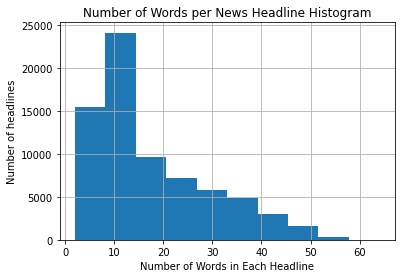

In [92]:
headlines_df['News'].apply(lambda x: len(x.split())).hist();
plt.xlabel('Number of Words in Each Headline')
plt.ylabel('Number of headlines')
plt.title('Number of Words per News Headline Histogram')

In [95]:
mean_len = headlines_df['News'].apply(lambda x: len(x.split())).mean()
std_len = headlines_df['News'].apply(lambda x: len(x.split())).std()
min_len = headlines_df['News'].apply(lambda x: len(x.split())).min()
max_len = headlines_df['News'].apply(lambda x: len(x.split())).max()

mean_len, std_len, min_len, max_len

(17.606775425199583, 11.413049858132041, 2, 64)

In [98]:
dija_df = pd.read_csv('./archive/Combined_News_DJIA.csv')

In [102]:
dija_df['Date'].nunique()

1989

### Tokenization and lemmatization with Gensim and Spacy

In [36]:
from tqdm import tqdm
def tokenize_headlines(headlines):
    for headline in headlines:
        yield(gensim.utils.simple_preprocess(str(headline), deacc=True))
        
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

### Vectorize headlines with CountVectorizer

In [30]:
def get_vectorized_data():
    #load data withs imple clearning
    headlines_df = load_headlines()
    headlines = headlines_df['News'].values.tolist()
    print('headlines loaded')
    
    # tokenize data
    headline_words = list(tokenize_headlines(headlines))
    print('headlines tokenized')
    
    # lamatize data
    headline_lemmatized = lemmatization(headline_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print('healines lemmatized')
    
    #vectorize text with count vectorizer
    vectorizer =  CountVectorizer(stop_words='english')
    headline_vectorized = vectorizer.fit_transform(headline_lemmatized)
    tf_feature_names = vectorizer.get_feature_names_out()
    print("headlines vectorized")
    
    # # Determine sparcity of the matrix
    # data_dense = headline_vectorized.todense()
    # # Compute Sparsicity = Percentage of Non-Zero cells
    # print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
    
    return headline_vectorized, tf_feature_names

### Function to run LDA with num_topics paramter

In [31]:
def run_lda(num_topics, vectorized_text):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state = 42, n_jobs = -1)
    lda.fit_transform(vectorized_text)
    return lda

#### Print the top n words from each topic

In [ ]:
# num_top_words = 8

# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         term_list = [feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]
#         print("topic %d:" % (topic_idx), term_list)


# display_topics(lda_model, tf_feature_names, num_top_words)

#### Print the headline most associated with each topic

In [38]:
# best_document_per_topic = np.argsort(lda_output, axis = 0)[::-1]
# for topic_index in range(0, 10):
#     best_index = best_document_per_topic[0, topic_index]
#     print("Highest topic", topic_index, "weight is document", 
#           best_index, ":", headline_lemmatized[best_index][0:20])

### Combine lda_output with dates and target to get features for supervised learning

In [127]:
def get_training_data(lda_output):
    # merge the vectors back with the corresponding dates
    headlines_df = load_headlines() 
    df = pd.DataFrame(lda_output, index = headlines_df['Date'].tolist()).reset_index().rename(columns = {'index' : 'Date'})
    # group the news vecs by their date and take the avergae of the vectors
    df = df.groupby('Date').mean()
    # load the targets and merge these to the vectors.  Drop all dates that don't have a target (days without tading)
    y = pd.read_csv('./archive/Combined_News_DJIA.csv')
    df = df.merge(right = y[['Date', 'Label']], left_index= True, right_on = 'Date')

    X = df.drop(columns = ['Date', 'Label'])
    y = df['Label']
    
    return X, y

### Supervised learning with topic-weights

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.dummy import DummyClassifier

In [166]:
estimators ={
    'base': DummyClassifier(strategy='most_frequent'),
    'log_reg' : LogisticRegression(),
    'rand_for' : RandomForestClassifier(),
    'svc' : SVC(),
    'xg_boost' : XGBClassifier(use_label_encoder=False)
}

def cross_vall_lda(X, y):

    cv_results = dict()
    for clf in estimators:
        results = cross_validate(estimators[clf], X, y, cv = 5, scoring = 'f1', n_jobs = -1)
        cv_results[clf] = results['test_score'].mean()

    return cv_results


In [182]:
def pipeline(headline_vectorized, num_topics):
    pipeline_results = dict()
    # get vectorized data

    # Train lda model for each value in num_topics
    for i in num_topics:
        lda_model = run_lda(num_topics = i, vectorized_text = headline_vectorized)
        
        # Transform headlines_vectorized to get topic weights per headlines
        lda_output = lda_model.transform(headline_vectorized)
        
        # get X and y from lda output
        X, y = get_training_data(lda_output = lda_output)

        cv_results = cross_vall_lda(X, y)

        pipeline_results[i] = cv_results
        print(f'Done with {i} topics')
        
    return pipeline_results

In [ ]:
headline_vectorized, tf_feature_names = get_vectorized_data()

In [115]:
values = ['Topic ' + str(i+1) for i in range(20)]
keys = [i for i in range(20)]
new_columns = dict(zip(keys, values))

In [122]:
# Sample to see the topic weights for each headline
lda_model = run_lda(num_topics = 20, vectorized_text = headline_vectorized)
lda_output = lda_model.transform(headline_vectorized)
pd.DataFrame(lda_output).head().rename(columns = new_columns, index= {0: 'headline 1', 1: 'headline 2', 2: 'headline 3', 3: 'headline 4', 4: 'headline 5'} )

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
headline 1,0.003333,0.003333,0.702796,0.003333,0.003333,0.003333,0.237204,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333
headline 2,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.671826,0.178174,0.008333,0.008333,0.008333,0.008333,0.008333
headline 3,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.762500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500
headline 4,0.002941,0.002941,0.002941,0.002941,0.002941,0.088950,0.651310,0.002941,0.002941,0.002941,0.002941,0.002941,0.209740,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941
headline 5,0.007143,0.007143,0.007143,0.181679,0.007143,0.007143,0.007143,0.159747,0.007143,0.007143,0.007143,0.537145,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143


In [125]:
num_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)


display_topics(lda_model, tf_feature_names, num_top_words)

topic 0: ['internet', 'government', 'access', 'online', 'freedom', 'website', 'datum', 'user', 'site', 'facebook']
topic 1: ['ban', 'oil', 'block', 'marriage', 'sale', 'spill', 'arm', 'say', 'company', 'destroy']
topic 2: ['year', 'old', 'man', 'sentence', 'death', 'ship', 'shoot', 'prison', 'murder', 'girl']
topic 3: ['state', 'drug', 'islamic', 'school', 'muslim', 'group', 'christian', 'kill', 'say', 'iraqi']
topic 4: ['child', 'abuse', 'police', 'say', 'photo', 'riot', 'video', 'torture', 'beat', 'sex']
topic 5: ['hit', 'kill', 'chinese', 'people', 'water', 'die', 'bomb', 'dead', 'earthquake', 'city']
topic 6: ['woman', 'right', 'human', 'rape', 'man', 'say', 'sex', 'law', 'case', 'migrant']
topic 7: ['news', 'british', 'mass', 'phone', 'scandal', 'money', 'company', 'hack', 'world', 'fund']
topic 8: ['food', 'refugee', 'make', 'iceland', 'say', 'bank', 'use', 'sell', 'child', 'debt']
topic 9: ['world', 'global', 'say', 'year', 'change', 'country', 'new', 'scientist', 'large', 'clim

In [126]:
headlines_df['News'].iloc[3]

'British Man Who Must Give Police 24 Hours Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime.'

In [183]:
%%time
pipeline_results = pipeline(headline_vectorized, num_topics = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80 ])

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 64.1 µs


In [169]:
results_df_mean = pd.DataFrame(pipeline_results)

In [170]:
results_df_mean

,5,10,15,20,25,30,40,50,60,70,80
base,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675,0.697675
log_reg,0.679031,0.687358,0.687617,0.693428,0.692749,0.698134,0.697476,0.697675,0.697675,0.697675,0.697675
rand_for,0.527982,0.585672,0.581772,0.581297,0.589046,0.602531,0.611483,0.605620,0.591412,0.587377,0.629032
svc,0.636301,0.635286,0.606648,0.600162,0.592221,0.597837,0.595224,0.601258,0.598333,0.616075,0.600395
xg_boost,0.548105,0.557091,0.543241,0.587457,0.553818,0.558585,0.586494,0.575424,0.568488,0.569987,0.565105


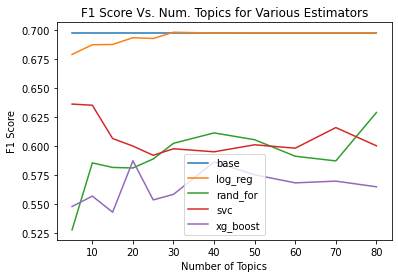

In [181]:
results_df_mean.reindex(sorted(results_df_mean.columns), axis=1).T.plot()
plt.xlabel('Number of Topics')
plt.ylabel('F1 Score')
plt.title('F1 Score Vs. Num. Topics for Various Estimators');